This project will show how adaptable neural networks can be, we will now attemp to use a neural network to learn the optimal move for Tic-Tac-Toe. We will approach this knowing that Tic-Tac-Toe is a deterministic game and that the optimal moves are already known.

To train our model, we will use a list of board positions followed by the optimal response for a number of different boards. We can reduce the amount of boards to train on by considering only board position that are differnt with regard to symmetry. The non-identity transformations of a Tic-Tac-Toe board are a rotation (in either direction ) of 90 degress, 180 degrees and 270 degress a horizontal reflection and a vertical reflection. Given this idea, we will use a shortlist of boards with optimal move, apply 2 random transformations, and then feed that into our neural network for learning. 

Since Tic-Tac-Toe is a deterministic game, it is worth noting that whoever goes first should either win or draw. We will hope a model that can respond to our moves optimally and ultimately result in a raw.

To check how our model is performing, we will do 2 things. The first check we will perform is to remove a position and an optimal move row from our training set. This will allow us to see if the neural network can generalize a move it has not seen before. The second way to evaluate our model is to actually play a game agasint it at the end

https://github.com/lahoangquy/Tic-tac-toe-with-Neural-Network-YouTube

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [ ]:
import tensorflow as tf
#import matplotlib.pyplot as plt
import csv
import numpy as np
import random

In [ ]:
# Print a board
def print_board(board):
    symbols = ['O', ' ', 'X']
    board_plus1 = [int(x) + 1 for x in board]
    board_line1 = ' {} | {} | {}'.format(symbols[board_plus1[0]],
                                         symbols[board_plus1[1]],
                                         symbols[board_plus1[2]])
    board_line2 = ' {} | {} | {}'.format(symbols[board_plus1[3]],
                                         symbols[board_plus1[4]],
                                         symbols[board_plus1[5]])
    board_line3 = ' {} | {} | {}'.format(symbols[board_plus1[6]],
                                         symbols[board_plus1[7]],
                                         symbols[board_plus1[8]])
    print(board_line1)
    print('___________')
    print(board_line2)
    print('___________')
    print(board_line3)
# Data Augmentation
symmetry = ['rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h']

# Given a board, a response, and a transformation, get the new board+response
def get_symmetry(board, play_response, transformation):
    """
    :param board: list of integers 9 long:
     opposing mark = -1
     friendly mark = 1
     empty space = 0
    :param play_response: integer of where response is (0-8)
    :param transformation: one of five transformations on a board:
     'rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h'
    :return: tuple: (new_board, new_response)
    """
    if transformation == 'rotate180':
        new_response = 8 - play_response
        return board[::-1], new_response
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(play_response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(play_response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return [value for item in tuple_board for value in item], new_response
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(play_response)
        return board[6:9] + board[3:6] + board[0:3], new_response
    elif transformation == 'flip_h':  # flip_h = rotate180, then flip_v
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(play_response)
        new_board = board[::-1]
        return new_board[6:9] + new_board[3:6] + new_board[0:3], new_response
    else:
        raise ValueError('Method not implemented.')


# Read in board move csv file
def get_moves_from_csv(csv_file):
    """
    :param csv_file: csv file location containing the boards w/ responses
    :return: moves: list of moves with index of best response
    """
    play_moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            play_moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return play_moves


# Get random board with optimal move
def get_rand_move(play_moves, rand_transforms=2):
    """
    :param play_moves: list of the boards w/responses
    :param rand_transforms: how many random transforms performed on each
    :return: (board, response), board is a list of 9 integers, response is 1 int
    """
    (board, play_response) = random.choice(play_moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for _ in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, play_response) = get_symmetry(board, play_response, random_transform)
    return board, play_response

# Get list of optimal moves w/ responses
moves = get_moves_from_csv('base_tic_tac_toe_moves.csv')
# Create a train set:
train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move(moves))

# To see if the network learns anything new, we will remove
# all instances of the board [-1, 0, 0, 1, -1, -1, 0, 0, 1],
# which the optimal response will be the index '6'.  We will
# Test this at the end.
test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
train_set = [x for x in train_set if x[0] != test_board]

def init_weights(shape):
    return tf.Variable(tf.random.normal(shape))

A1 = init_weights([9, 81])
bias1 = init_weights([81])
A2 = init_weights([81, 9])
bias2 = init_weights([9])

# Initialize input data
X = tf.keras.Input(dtype=tf.float32, batch_input_shape=[None, 9])
hidden_output = tf.keras.layers.Lambda(lambda x: tf.nn.sigmoid(tf.add(tf.matmul(x, A1), bias1)))(X)
# Note: we don't take the softmax at the end because our cost function does that for us
final_output = tf.keras.layers.Lambda(lambda x: tf.add(tf.matmul(x, A2), bias2))(hidden_output)
model = tf.keras.Model(inputs=X, outputs=final_output, name="tic_tac_toe_neural_network")

optimizer = tf.keras.optimizers.SGD(0.025)

loss_vec = []
for i in range(10000):
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data = [train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])

    # Open a GradientTape.
    with tf.GradientTape(persistent=True) as tape:

        # Forward pass.
        output = model(np.array(x_input, dtype=float))

        # Apply loss function (Cross Entropy loss)
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=y_target))
        loss_vec.append(loss)

    # Get gradients of loss with reference to the weights and bias variables to adjust.
    gradients_A1 = tape.gradient(loss, A1)
    gradients_b1 = tape.gradient(loss, bias1)
    gradients_A2 = tape.gradient(loss, A2)
    gradients_b2 = tape.gradient(loss, bias2)

    # Update the weights and bias variables of the model.
    optimizer.apply_gradients(zip([gradients_A1, gradients_b1, gradients_A2, gradients_b2],
                                  [A1, bias1, A2, bias2]))

    if i % 500 == 0:
        print('Iteration: {}, Loss: {}'.format(i, loss))

The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(9, 81) dtype=float32>
  <tf.Variable 'Variable:0' shape=(81,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=(81, 9) dtype=float32>
  <tf.Variable 'Variable:0' shape=(9,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Iteration: 0, Loss: 6.431041240692139
Iteration: 500, Loss: 2.016533851623535
Iteration: 1000, Loss: 1.6385409832000732
Iteration: 1500, Loss: 1.755265712738037
Iteration: 2000, Loss: 1.5266941785812378
Iteration: 2500, Loss: 1.619760274887085
Iteration: 3000, Loss: 1.5771849155426025
Iteration: 3500, Loss: 1.320859670639038
Iteration: 4000, Loss: 1.182477593421936
Iteration: 4500, Loss: 1.0673573017120361
Iteration: 5000, Loss: 1.1314177513122559
Iteration: 5500, Loss: 1.1016783714294434
Iteration: 6000, Loss: 1.2095882892608643
Iteration: 6500, Loss: 0.9774430990219116
Iteration: 7000, Loss: 1.1682740449905396
Iteration: 7500, Loss: 1.0042903423309326
Iteration: 8000, Loss: 0.9091327786445618
Iteration: 8500, Loss: 0.9796607494354248
Iteration: 9000, Loss: 1.018488883972168
Iteration: 9500, Loss: 0.9101143479347229


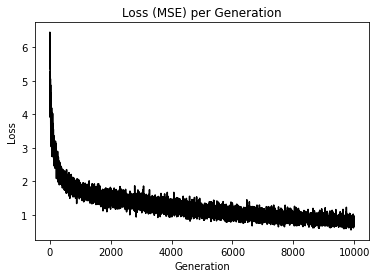

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_vec, 'k-', label='Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In the above plot, we did plot the loss over the training steps.
To test the model, we do need to see how it performs on the test board that we removed from the training set. We are hoping that the model can generalize and predict the optimal index for moving, which will be index number 6 and most of the model will succeed.

In [ ]:
# Make Prediction:
test_boards = [test_board]
logits = model.predict(test_boards)
predictions = tf.argmax(logits, 1)
print(predictions)

tf.Tensor([6], shape=(1,), dtype=int64)


To evaluate our mpodel, we do need to play against our trained model. To do this we need to create a function that will check for a win. Thous way, our program will know when to stop asking for more moves.

In [ ]:
# Declare function to check for win
def check(board):
    wins = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
    for ix in range(len(wins)):
        if board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == 1.:
            return 1
        elif board[wins[ix][0]] == board[wins[ix][1]] == board[wins[ix][2]] == -1.:
            return -1
    return 0

Now we can loop through and play a game with out model. We can start with a blank board (all zeros). We will ask the user to input an index (0-8) of where to play and we can feed taht into the model for a prediction. For the model's move, we can take the largest available  prediction that is also an open space.

In [ ]:
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0
while not win_logical:
    player_index = input('Input index of your move (0-8): ')
    num_moves += 1
    # Add player move to game
    game_tracker[int(player_index)] = 1.
    
    # Get model's move by first getting all the logits for each index
    [potential_moves] = model(np.array([game_tracker], dtype=float))
    # Now find allowed moves (where game tracker values = 0.0)
    allowed_moves = [ix for ix, x in enumerate(game_tracker) if x == 0.0]
    # Find best move by taking argmax of logits if they are in allowed moves
    model_move = np.argmax([x if ix in allowed_moves else -999.0 for ix, x in enumerate(potential_moves)])
    
    # Add model move to game
    game_tracker[int(model_move)] = -1.
    print('Model has moved')
    print_board(game_tracker)
    # Now check for win or too many moves
    if check(game_tracker) == -1 or num_moves >= 5:
        print('Game Over!')
        win_logical = True
    elif check(game_tracker) == 1:
        print('Congratulations, You won!')
        win_logical = True

Input index of your move (0-8): 1
Model has moved
 O | X |  
___________
   |   |  
___________
   |   |  
Input index of your move (0-8): 3
Model has moved
 O | X |  
___________
 X |   |  
___________
   |   | O
Input index of your move (0-8): 6
Model has moved
 O | X | O
___________
 X |   |  
___________
 X |   | O
Input index of your move (0-8): 7
Model has moved
 O | X | O
___________
 X | O |  
___________
 X | X | O
Game Over!


As can be seen from the above result, Our model is not perfect and we can  beat the model easily

We did train a neural network to play Tic-Tac-Toe by feeding in board positions and a 9-dimensional vector and predicted the optimal response. We only had to feed in a few possible Tic-Tac-Toe boards and apply random trnasformations to each board to increase the training set size.

To test our algorithm we dod remove all instances of 1 specific board and saw whether our model could generalize to predict the optimal response. Finally we did play a same game against our model. This model is not perfect yet. using more data or applying a more complex neural network architecture could be done to improve it. But the better thing we can do is to change the algorithm to reinforcement learning.